In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout, Input
from tqdm import tqdm
import pickle
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
import itertools
from sklearn.utils import shuffle
from tensorflow.keras import regularizers
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig, TFRobertaModel

In [2]:
data_file='New Data.csv'
data=pd.read_csv(data_file,encoding='ISO-8859-1')

data.head()

,Id,Judgment,Judgment Status
0,1,appeal judgment decre bombay high court stone ...,1
1,2,applic articl 32 1 constitut enforc applic fun...,2
2,3,appeal judgment high court hyderabad articl 37...,0
3,4,appeal articl 3744 constitut judgment decre hi...,0
4,5,petit art 136 constitut pray special leav appe...,3


In [3]:
data=data.rename(columns = {'Judgment Status': 'label', 'Judgment': 'text'}, inplace = False)

print('Available labels: ',data.label.unique())

num_classes=len(data.label.unique())

data.head()

Available labels:  [1 2 0 3]


,Id,text,label
0,1,appeal judgment decre bombay high court stone ...,1
1,2,applic articl 32 1 constitut enforc applic fun...,2
2,3,appeal judgment high court hyderabad articl 37...,0
3,4,appeal articl 3744 constitut judgment decre hi...,0
4,5,petit art 136 constitut pray special leav appe...,3


In [4]:
dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

loading file vocab.txt from cache at C:\Users\saray/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\1c4513b2eedbda136f57676a34eea67aba266e5c\vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at C:\Users\saray/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\1c4513b2eedbda136f57676a34eea67aba266e5c\tokenizer_config.json
loading configuration file config.json from cache at C:\Users\saray/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\1c4513b2eedbda136f57676a34eea67aba266e5c\config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,


In [5]:
max_len=100
sentences=data['text']
labels=data['label']
len(sentences),len(labels)

(370, 370)

In [6]:
dbert_tokenizer.tokenize(sentences[0])

['appeal',
 'judgment',
 'dec',
 '##re',
 'bombay',
 'high',
 'court',
 'stone',
 'c',
 '##j',
 'co',
 '##ya',
 '##je',
 'j',
 'date',
 '20th',
 'march',
 '1947',
 'appeal',
 '42',
 '1946',
 'rev',
 '##ers',
 'judgment',
 'cha',
 '##gl',
 '##a',
 'j',
 'dismiss',
 'app',
 '##lic',
 'made',
 'respond',
 'en',
 '##t',
 'indian',
 'ar',
 '##bit',
 '##r',
 'act',
 '1940',
 'pray',
 'inter',
 'ali',
 '##a',
 'ar',
 '##bit',
 '##r',
 'agreement',
 'contain',
 'certain',
 'contract',
 'note',
 'sent',
 'app',
 '##el',
 'respond',
 'dec',
 '##lar',
 'invalid',
 'void',
 'set',
 'as',
 '##id',
 'award',
 'made',
 'ar',
 '##bit',
 '##r',
 'appoint',
 'said',
 'contract',
 'note',
 'mc',
 'set',
 '##al',
 '##va',
 '##d',
 'ram',
 '##esh',
 '##war',
 'nat',
 '##h',
 'app',
 '##el',
 'lan',
 '##t',
 'ck',
 'da',
 '##ph',
 '##tar',
 '##i',
 'b',
 'sen',
 'k',
 '##t',
 'des',
 '##ai',
 'respond',
 '1950',
 'march',
 '14',
 'judgment',
 'court',
 'del',
 '##iv',
 'da',
 'j',
 '##thi',
 'appeal',
 'ari

In [7]:
dbert_inp=dbert_tokenizer.encode_plus(sentences[0],add_special_tokens = True,max_length =20,pad_to_max_length = True,truncation=True)
dbert_inp

C:\Users\saray\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'input_ids': [101, 5574, 8689, 11703, 2890, 11831, 2152, 2457, 2962, 1039, 3501, 2522, 3148, 6460, 1046, 3058, 3983, 2233, 4006, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [8]:
dbert_inp['input_ids']

[101,
 5574,
 8689,
 11703,
 2890,
 11831,
 2152,
 2457,
 2962,
 1039,
 3501,
 2522,
 3148,
 6460,
 1046,
 3058,
 3983,
 2233,
 4006,
 102]

In [9]:
id_inp=np.asarray(dbert_inp['input_ids'])
mask_inp=np.asarray(dbert_inp['attention_mask'])
out=roberta_model([id_inp.reshape(1,-1),mask_inp.reshape(1,-1)])
type(out),out

(transformers.modeling_tf_outputs.TFBaseModelOutputWithPoolingAndCrossAttentions,
 TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(1, 20, 768), dtype=float32, numpy=
 array([[[-8.64602327e-02,  3.83437052e-02,  8.60876963e-03, ...,
          -9.20078605e-02, -8.18481073e-02,  4.35207784e-02],
         [-1.38064593e-01, -6.68594688e-02, -1.37911718e-02, ...,
          -1.69272780e-01, -1.37464687e-01,  1.45879075e-01],
         [-7.07464740e-02,  1.25674590e-01, -1.15413591e-02, ...,
          -1.45848662e-01, -7.72131085e-02,  1.06089428e-01],
         ...,
         [ 3.24685462e-02,  1.13736838e-04,  3.24796885e-04, ...,
          -3.90083909e-01, -1.09813750e-01,  1.18597345e-02],
         [-6.84536546e-02, -9.81280431e-02,  1.52203590e-02, ...,
          -2.04375044e-01, -8.03839713e-02, -7.43727374e-04],
         [-1.19136855e-01, -1.21927276e-01,  5.82877360e-02, ...,
          -4.79852706e-02, -1.22639745e-01,  1.58256382e-01]]],
       dtype=f

In [10]:
dbert_tokenizer.decode(dbert_inp['input_ids'])

'[CLS] appeal judgment decre bombay high court stone cj coyaje j date 20th march 1947 [SEP]'

In [11]:
def create_model():
    inps = Input(shape = (max_len,), dtype='int64')
    masks= Input(shape = (max_len,), dtype='int64')
    dbert_layer = roberta_model(inps, attention_mask=masks)[0][:,0,:]
    dense = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.01))(dbert_layer)
    dropout= Dropout(0.5)(dense)
    pred = Dense(4, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)
    model = tf.keras.Model(inputs=[inps,masks], outputs=pred)
    print(model.summary())
    return model  

In [12]:
model=create_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                           

In [13]:
input_ids=[]
attention_masks=[]

for sent in sentences:
    dbert_inps=dbert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
    input_ids.append(dbert_inps['input_ids'])
    attention_masks.append(dbert_inps['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)
len(input_ids),len(attention_masks),len(labels)

(370, 370, 370)

In [14]:
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.25)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

model.compile(loss=loss,optimizer=optimizer, metrics=[metric])

Train inp shape (277, 100) Val input shape (93, 100)
Train label shape (277,) Val label shape (93,)
Train attention mask shape (277, 100) Val attention mask shape (93, 100)


In [15]:
history=model.fit([train_inp,train_mask],train_label,batch_size = 32,epochs = 10,validation_data=([val_inp,val_mask],val_label))

Epoch 1/10


C:\Users\saray\anaconda3\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


9/9 [==============================] - 131s 13s/step - loss: 7.5809 - accuracy: 0.2816 - val_loss: 7.4566 - val_accuracy: 0.3763
Epoch 2/10
9/9 [==============================] - 115s 13s/step - loss: 7.5380 - accuracy: 0.3213 - val_loss: 7.4559 - val_accuracy: 0.2903
Epoch 3/10
9/9 [==============================] - 117s 13s/step - loss: 7.4675 - accuracy: 0.3069 - val_loss: 7.3551 - val_accuracy: 0.3763
Epoch 4/10
9/9 [==============================] - 113s 13s/step - loss: 7.3309 - accuracy: 0.3682 - val_loss: 7.2041 - val_accuracy: 0.3978
Epoch 5/10
9/9 [==============================] - 114s 13s/step - loss: 7.2382 - accuracy: 0.3827 - val_loss: 7.1069 - val_accuracy: 0.3871
Epoch 6/10
9/9 [==============================] - 122s 14s/step - loss: 7.0755 - accuracy: 0.4440 - val_loss: 7.0973 - val_accuracy: 0.3871
Epoch 7/10
9/9 [==============================] - 119s 13s/step - loss: 7.0552 - accuracy: 0.4693 - val_loss: 7.1000 - val_accuracy: 0.3441
Epoch 8/10
9/9 [===============

In [16]:
preds = model.predict([val_inp,val_mask],batch_size=16)

6/6 [==============================] - 18s 2s/step


In [17]:
pred_labels = preds.argmax(axis=1)
f1 = f1_score(val_label,pred_labels,average='weighted')
f1

0.4108203317169162

In [20]:
model.save('DistilBERT-RoBERTa.h5')

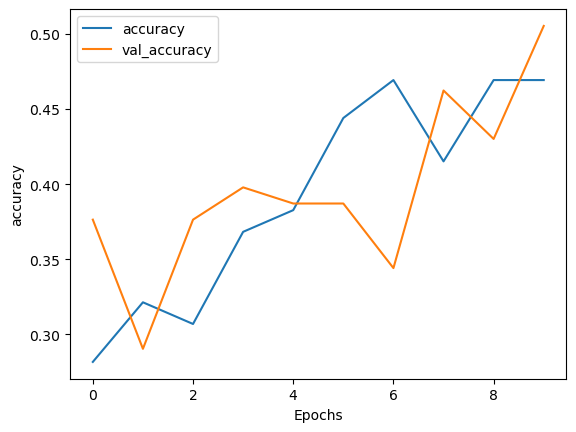

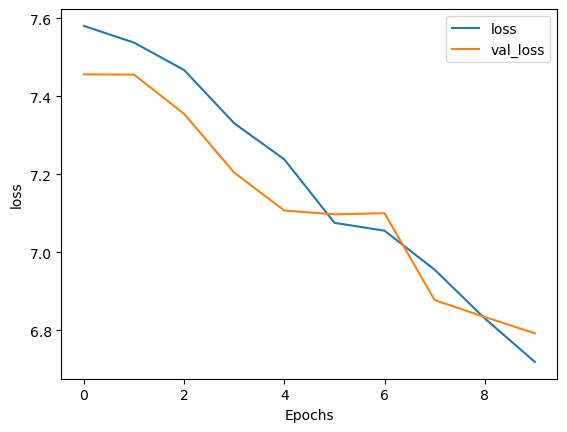

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")